<a href="https://colab.research.google.com/github/shenith084/Data-Science-Report/blob/main/Data_Science_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment - 01 End-to-End Data Science**
# **Report**

##Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

Load the dataset


In [4]:
df = pd.read_csv('/content/hospital_readmissions_30k.csv')

Show first five rows

In [5]:
df.head()

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


Show information about the Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             30000 non-null  int64  
 1   age                    30000 non-null  int64  
 2   gender                 30000 non-null  object 
 3   blood_pressure         30000 non-null  object 
 4   cholesterol            30000 non-null  int64  
 5   bmi                    30000 non-null  float64
 6   diabetes               30000 non-null  object 
 7   hypertension           30000 non-null  object 
 8   medication_count       30000 non-null  int64  
 9   length_of_stay         30000 non-null  int64  
 10  discharge_destination  30000 non-null  object 
 11  readmitted_30_days     30000 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 2.7+ MB


In [7]:
df.dtypes

,0
patient_id,int64
age,int64
gender,object
blood_pressure,object
cholesterol,int64
bmi,float64
diabetes,object
hypertension,object
medication_count,int64
length_of_stay,int64


Drop the patient_id


In [8]:
df = df.drop('patient_id', axis=1)

In [9]:
df.duplicated().sum()

np.int64(0)

blood pressure calumn change in to float

In [10]:
df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True).astype(float)
df = df.drop('blood_pressure', axis=1)

Encoding Binary and Categorical Variables

In [11]:
binary_map = {'Yes': 1, 'No': 0}
df['diabetes'] = df['diabetes'].map(binary_map)
df['hypertension'] = df['hypertension'].map(binary_map)
df['readmitted_30_days'] = df['readmitted_30_days'].map(binary_map)

One-hot encoding for multi-class categoricals

In [12]:
df = pd.get_dummies(df, columns=['gender', 'discharge_destination'], drop_first=True)

Fixing Impossible Values

In [13]:
df = df[(df['age'] > 0) & (df['age'] <= 110)]
df = df[df['length_of_stay'] > 0]
df = df[(df['systolic_bp'] > 50) & (df['systolic_bp'] < 250)]
df = df[(df['diastolic_bp'] > 30) & (df['diastolic_bp'] < 150)]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age                                     30000 non-null  int64  
 1   cholesterol                             30000 non-null  int64  
 2   bmi                                     30000 non-null  float64
 3   diabetes                                30000 non-null  int64  
 4   hypertension                            30000 non-null  int64  
 5   medication_count                        30000 non-null  int64  
 6   length_of_stay                          30000 non-null  int64  
 7   readmitted_30_days                      30000 non-null  int64  
 8   systolic_bp                             30000 non-null  float64
 9   diastolic_bp                            30000 non-null  float64
 10  gender_Male                             30000 non-null  bo

Handling Missing Data

In [15]:
numeric_cols = ['age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay', 'systolic_bp', 'diastolic_bp']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

Outlier Detection and Correction

In [16]:
for col in numeric_cols:
    lower_limit = df[col].quantile(0.01)
    upper_limit = df[col].quantile(0.99)
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

Heatmap

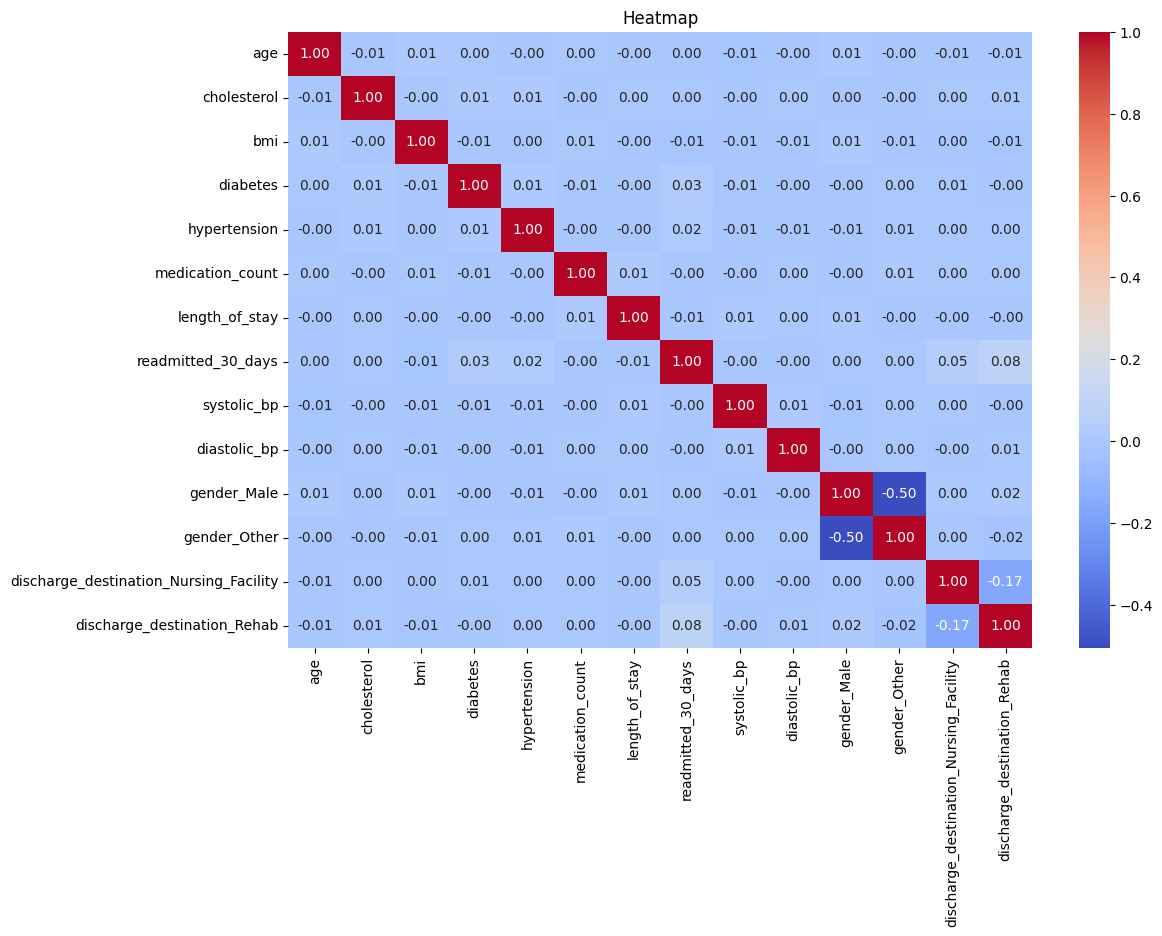

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Heatmap")
plt.show()

Boxplot BMI vs Readmission

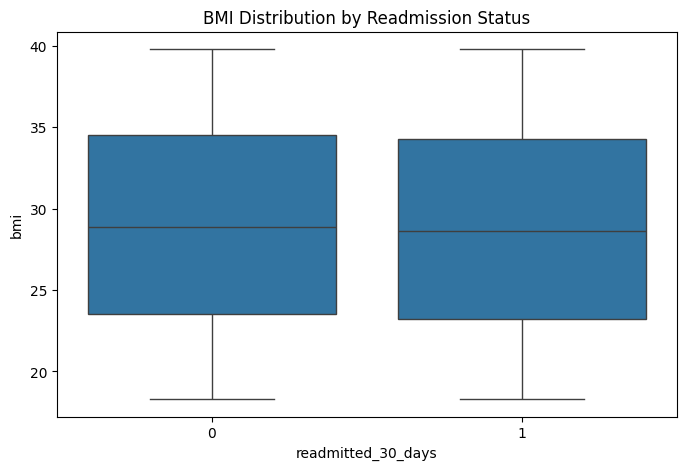

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='readmitted_30_days', y='bmi', data=df)
plt.title("BMI Distribution by Readmission Status")
plt.show()

Histogram: Distribution of Length of Stay

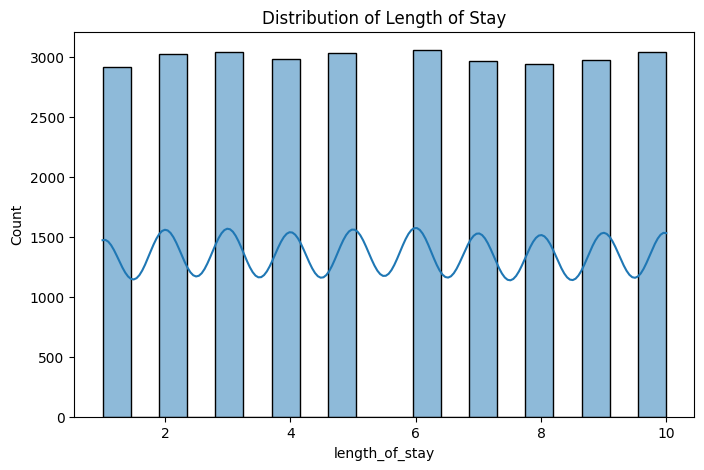

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(df['length_of_stay'], bins=20, kde=True)
plt.title("Distribution of Length of Stay")
plt.show()

Data Set >Train-Test Split and Scaling

In [20]:
X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Scale numeric features

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Create Dictionary to store result

In [23]:
results = {}

def evaluate_model(name, model, X_t, y_t):
    y_pred = model.predict(X_t)
    y_prob = model.predict_proba(X_t)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_t, y_pred),
        'Precision': precision_score(y_t, y_pred),
        'Recall': recall_score(y_t, y_pred),
        'F1-Score': f1_score(y_t, y_pred),
        'ROC-AUC': roc_auc_score(y_t, y_prob)
    }
    print(f"--- {name} Performance ---")
    print(classification_report(y_t, y_pred))

Logistic Regression Model

In [24]:
log_param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']}
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_param_grid, cv=5, scoring='roc_auc')
log_grid.fit(X_train_scaled, y_train)

best_log_reg = log_grid.best_estimator_
evaluate_model('Logistic Regression', best_log_reg, X_test_scaled, y_test)

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5265
           1       0.00      0.00      0.00       735

    accuracy                           0.88      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.77      0.88      0.82      6000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_